<a href="https://colab.research.google.com/github/RuobingBai/Detection-of-Vulnerable-Individuals-Using-NLP-of-Helpline-Records/blob/main/Deep_learning_model(2)_Recurrent_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***2.5 Recurrent Neural Networks***

## **Load Packages**

In [ ]:
# !pip install -U tensorflow==2.2 as tf

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# Use Tokenizer to vectorize a text corpus into a list of integers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
! pip install imblearn
! pip install delayed
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from collections import Counter
from sklearn import metrics
from sklearn.metrics import precision_score,recall_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.layers import SimpleRNN, Dense, MaxPooling1D, LSTM

In [ ]:
# Set up for where to save the figures
import os
PROJECT_ROOT_DIR = "figures"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
  print("Saving figure", fig_id)
  if tight_layout:
    plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## **Load Cleaned Data**

In [ ]:
import time
start = time.time()
#read data in chunks of 1 million rows at a time
chunk = pd.read_csv('Cleaned.csv',chunksize=1000000)
end = time.time()
print("Read csv with chunks: ",(end-start),"sec")
data = pd.concat(chunk)

Read csv with chunks:  0.011981725692749023 sec


In [ ]:
data1 = data.dropna(subset = ["Description"])

In [ ]:
# We just re-do sentence_train, sentence_test, y_train, y_test from train_test_split

sentences = data1['lemma_str'].values
y = data1['Break Confidentiality?'].values

# Split into train and validation set
sentence_train, sentence_test, y_train, y_test = train_test_split(sentences, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
# num_words: setting the size of the vocabulary
## Perhaps here i should add oov_token="<OOV>" to represent words not shown up in the word index generated from training dataset
tokenizer = Tokenizer(num_words=5000, oov_token='OOV')
tokenizer.fit_on_texts(sentence_train)

sentence_train = tokenizer.texts_to_sequences(sentence_train)
sentence_test = tokenizer.texts_to_sequences(sentence_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentence_train[2])

[57, 3, 726, 4333, 24, 3, 74, 1, 1216, 146, 56, 113, 24, 177, 578, 123, 129, 150, 29, 246, 376, 3, 92, 222, 53, 18, 29, 34, 14, 311, 194, 84, 34, 14, 16, 215, 141, 32, 310, 531, 14, 86, 311, 890, 664, 34, 14, 12, 317, 181, 103, 61, 862, 48, 664, 606, 14, 1989, 181, 29, 3, 929, 26, 5, 123, 129, 12, 1, 8, 153]


In [ ]:
maxlen = 100 # it is the desired length of sentence you want to keep align with
sentence_train = pad_sequences(sentence_train, padding='post', maxlen=maxlen)
sentence_test = pad_sequences(sentence_test, padding='post', maxlen=maxlen)

print(sentence_train[0, :])

[   6   39  199    2   97    4   13   12   18   12  876  152  147   33
   11   33   82   49   16   21   22   46    5  270    2   43   48   46
   27   71    6   32  166   71   67   63   80  203  152  140  123  129
    2   36  198   59   59   38  154 1379 1277   54 3462   43   48   46
  116   20   71    6   80  523  280  150   23   36   50  198  115   96
   28   85   38    1   27   54   22 2080    2   43   48  115   48   37
   27   32   67   63   20   36  158   62   28   28   38  154  130   62
   43    6]


In [ ]:
# Smooth the unbalanced data
smo = SMOTE()

# Only need to balance the training data
x_train, y_train = smo.fit_resample(sentence_train, y_train)

# Check again the balance of dataset
print('Counter(y_train)\n',Counter(y_train)) # Employ Counter()

Counter(y_train)
 Counter({0: 8245, 1: 8245})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Change the "sentence_test" to "x_test"
x_test = sentence_test

You can observe that at some point the accuracy stopped to improve, which can happen because of the vanishing gradient problem. This kind of problem is harder to detect than the exploding gradient problem and will demand deeper analysis by the data scientist. Researchers found a model architecture way to solve this problem, which you will study later in this course. Instead of using SimpleRNN cells, you can use the more complex ones such as Gated Recurrent Unit (GRU) and Long Short-Term Memory (LSTM) cells.

### **(1) Simple RNN**

In [ ]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
vocab_size

44904

In [ ]:
model1 = Sequential()
# Add an Embedding layer expecting input vocab of size 37763, and
# output embedding dimension of size 64.
max_len=100
model1.add(layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len))

# Add a LSTM layer with 128 internal units.
model1.add(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2))

# Add a Dense layer with 10 units.
model1.add(layers.Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           2873856   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,972,801
Trainable params: 2,972,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history1 = model1.fit(x_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_split=0.2,
                    batch_size=50)


# Method '.evaluate()' shows the loss and accuracy
loss, accuracy = model1.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model1.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9874
Testing Accuracy:  0.9740


Saving figure simpleRNN-loss


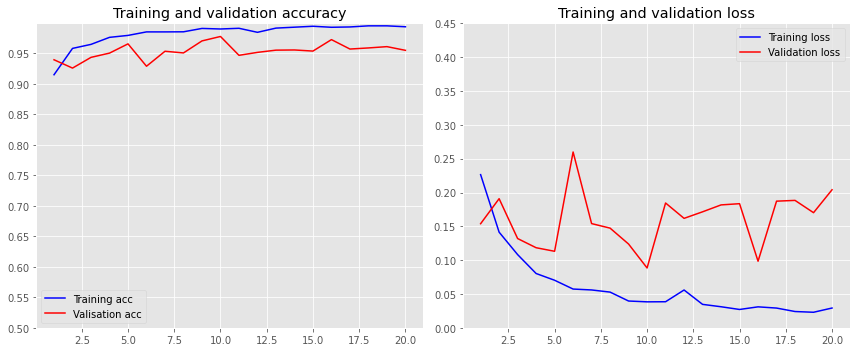

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Valisation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    # set the axis ticks
    my_y_ticks = np.arange(0.5, 1, 0.05)
    # my_x_ticks = np.arange(-2, 2, 0.3)
    # plt.xticks(my_x_ticks)
    plt.yticks(my_y_ticks)

    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    # set the axis ticks
    my_y_ticks = np.arange(0, 0.5, 0.05)
    # my_x_ticks = np.arange(-2, 2, 0.3)
    # plt.xticks(my_x_ticks)
    plt.yticks(my_y_ticks)

plot_history(history1)
save_fig("simpleRNN-loss")

Saving figure simpleRNN-AUC


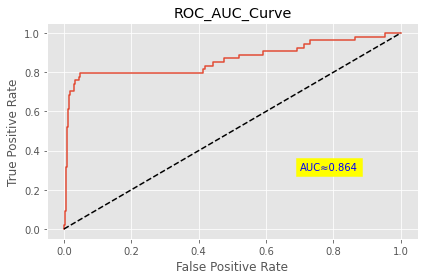

ROC_AUC_Score: 86.43%


In [ ]:
y_test_pred = model1.predict(x_test)
y_test_pred

# # Show a precision and recall metrics
# print("Recall Score","{:.2%}".format(recall_score(y_test, y_test_pred)))
# print("Precision Score:","{:.2%}".format((precision_score(y_test, y_test_pred))))

# Check the ROC curve
# Calculate the roc metrics
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.plot(fpr, tpr)

# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC_AUC_Curve")
plt.plot([0, 1], [0, 1], "k--")
plt.text(0.7,0.3,"AUC≈0.864", color="blue", backgroundcolor="yellow")
save_fig("simpleRNN-AUC")
plt.show()

# Print the AUC
print("ROC_AUC_Score:","{:.2%}".format(roc_auc_score(y_test, y_test_pred)))

In [ ]:
y_test_pred_class = model1.predict_classes(x_test, verbose=0)

# reduce to 1-d array
y_test_pred_class = y_test_pred_class[:,0]
y_test_pred_class

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
# accuracy: (tp + tn) / (p + n)
print('Accuracy for test set:', "{:.2%}".format(accuracy_score(y_test, y_test_pred_class)))
print('Accuracy for train set:', "{:.2%}".format(accuracy_score(y_train, model1.predict_classes(x_train))))

# precision tp / (tp + fp)
print("Precision:", "{:.2%}".format(precision_score(y_test, y_test_pred_class)))


# recall: tp / (tp + fn)
print("Recall:", "{:.2%}".format(recall_score(y_test, y_test_pred_class)))

# f1: 2 tp / (2 tp + fp + fn)
print("F1-score:", "{:.2%}".format(f1_score(y_test, y_test_pred_class)))

Accuracy for test set: 97.40%


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy for train set: 98.74%
Precision: 49.35%
Recall: 70.37%
F1-score: 58.02%


### **(2) CNNs & RNNs**

In [ ]:
model_mul = Sequential()
# output embedding dimension of size 64.
max_len=100
model_mul.add(layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len))
model_mul.add(layers.Conv1D(64, 5, activation="relu"))
model_mul.add(MaxPooling1D(pool_size=2))
model_mul.add(LSTM(100))
model_mul.add(layers.Dense(units = 1, activation='sigmoid'))

model_mul.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])


model_mul.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           2873856   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 64)            20544     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,960,501
Trainable params: 2,960,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_mul = model_mul.fit(x_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_split=0.2,
                    batch_size=50)

# Method '.evaluate()' shows the loss and accuracy
loss, accuracy = model_mul.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_mul.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9959
Testing Accuracy:  0.9490


Saving figure cnn+rnn-loss


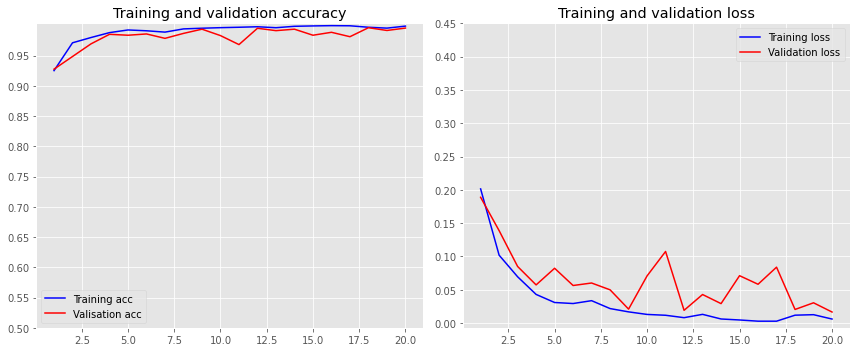

In [ ]:
plot_history(history_mul)
save_fig("cnn+rnn-loss")

Saving figure cnn+rnn-auc


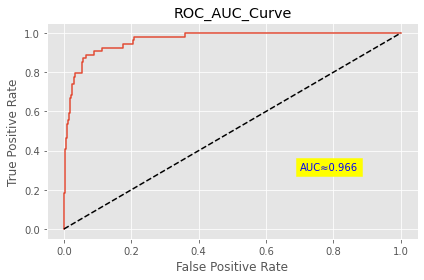

ROC_AUC_Score: 96.60%


In [ ]:
y_test_pred = model_mul.predict(x_test)
y_test_pred

# # Show a precision and recall metrics
# print("Recall Score","{:.2%}".format(recall_score(y_test, y_test_pred)))
# print("Precision Score:","{:.2%}".format((precision_score(y_test, y_test_pred))))

# Check the ROC curve
# Calculate the roc metrics
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.plot(fpr, tpr)

# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC_AUC_Curve")
plt.plot([0, 1], [0, 1], "k--")
plt.text(0.7,0.3,"AUC≈0.966", color="blue", backgroundcolor="yellow")
save_fig("cnn+rnn-auc")
plt.show()

# Print the AUC
print("ROC_AUC_Score:","{:.2%}".format(roc_auc_score(y_test, y_test_pred)))

In [ ]:
y_test_pred_class = model_mul.predict_classes(x_test, verbose=0)

# reduce to 1-d array
y_test_pred_class = y_test_pred_class[:,0]
y_test_pred_class

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, ..., 1, 0, 0], dtype=int32)

In [ ]:
# accuracy: (tp + tn) / (p + n)
print('Accuracy for test set:', "{:.2%}".format(accuracy_score(y_test, y_test_pred_class)))
print('Accuracy for train set:', "{:.2%}".format(accuracy_score(y_train, model1.predict_classes(x_train))))

# precision tp / (tp + fp)
print("Precision:", "{:.2%}".format(precision_score(y_test, y_test_pred_class)))


# recall: tp / (tp + fn)
print("Recall:", "{:.2%}".format(recall_score(y_test, y_test_pred_class)))

# f1: 2 tp / (2 tp + fp + fn)
print("F1-score:", "{:.2%}".format(f1_score(y_test, y_test_pred_class)))

Accuracy for test set: 94.90%


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy for train set: 98.74%
Precision: 30.71%
Recall: 79.63%
F1-score: 44.33%
